# Intermediate notebook 2: stellar rotation rates
Stars rotate. This feature is inherently linked to stellar formation — the molecular clouds from which stars form need only very slightly rotate, and conservation of angular momentum makes sure that the final, formed star rotates, as well.

The rotation rate of a star at a given point in time tells us about its evolution, its magnetic field, etc. Stellar light curves (time-series photometry) offers a glimpse into the rotation rates of these bodies. The core idea is that stars are not homogeneous; rather, they can have cooler spots on their surface that rotate in and out of view. The classical picture is of a large single spot that yields a sinusoidal light curve, as an observer detects fewer photons when the spot is in view. In reality, stars are not so ideal — they may have multiple spots at once, and these spots evolve over time. But the general idea remains: the periodicity of a light curve is related to its rotation rate.

In this notebook, we will work through the key mechanics of identifying a star’s rotation period from its TESS light curve. We will then apply this to a large population of stars to understand how rotation rates vary across the M dwarf population.

# Learning objectives
- Understand how to extract stellar rotation rates from light curves
- Understand how the Nyquist-Shannon Sampling Theorem applies to finding stellar rotation rates

## Import Statements

* **numpy** is used for array manipulation.

* **matplotlib.pyplot** is used to display images and plot datasets.
* **lightkurve** allows us to easily interact with TESS light curves.


In [102]:
# arrays
import numpy as np

# unpacking files 
import tarfile
from tqdm import tqdm

# fits
from astropy.io import fits
from astropy.utils.data import download_file

# plotting
import matplotlib.pyplot as plt
from matplotlib import ticker

# stella CNN functions
import stella

# keras
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D

# sklearn for performance metrics
from sklearn import metrics

# lightkurve
from lightkurve.search import search_lightcurve

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

# set the numpy random seed
seed = 42
np.random.seed(seed)

# set the PYTHONHASHSEED seed
import os
os.environ['PYTHONHASHSEED']=str(seed)

# set python built-in random seed
import random
random.seed(seed)

# set tensorflow random seed
import tensorflow as tf
tf.random.set_seed(seed)

In [4]:
conda run pip install git+https://github.com/afeinstein20/stella

  Cloning https://github.com/afeinstein20/stella to /tmp/pip-req-build-kijqkcq1
  Resolved https://github.com/afeinstein20/stella to commit f9ffd78d1c7279012e870f3657812595f18eee74
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'

  Running command git clone --filter=blob:none --quiet https://github.com/afeinstein20/stella /tmp/pip-req-build-kijqkcq1


Note: you may need to restart the kernel to use updated packages.


In [5]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_stella_500.tar.gz'

In [6]:
file = tarfile.open(download_file(file_url, cache=True))
file.extractall('.')
file.close() # be sure to close files when you're finished with them!

In [7]:
data_dir = './hellouniverse_stella_500/'
ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+'Guenther_2020_flare_catalog.txt')

Reading in training set files.


100%|██████████| 62/62 [00:00<00:00, 414.73it/s]

502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



In [8]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    '''Determine indices of files without NaNs'''

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    # AS: how do we want to talk about functions? assume that people know how they work for the intermediate notebooks?
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]

In [44]:
# ticids = ['278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']
ticids = ['234295610']


# for all the selected targets, pull the available lightcurves using the lightkurve package
sectors = [1, 2] # only consider the first few sectors
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

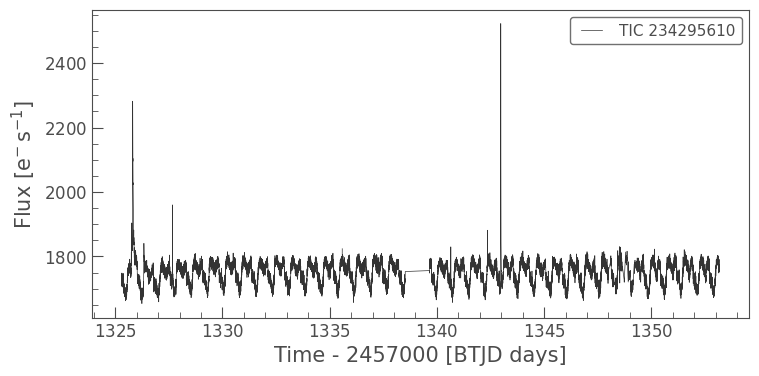

In [16]:
lc.plot()

This light curve is quite interesting. There's definitely at least one source of periodicity (the regularly spaced wiggles in the graph), and there are a few regions of high flux. Might they be flares?

To address the first bit—finding periodicity in the data—we need to calculate a *periodogram*. A periodogram is a mathematical estimate of how strong different periods are in a dataset. (AS: link here? describe more?)

Before we call the periodogram, we want to consider what a maximum period of the pulsations might be. Based on some science cases, we might be interested in stellar periodicity that is quite long. Betelgeuse, for instance, is a star that <a href="https://arxiv.org/abs/2306.00287">has quite interesting pulsations</a> on the order of 2200 days. However, we're fundamentally limited by our observing strategy based on something called the Nyquist-Shannon Theorem.

DIFFERENCES from just a "basic" periodogram:
- treating the lightcurves "very nicely" to capture some of the secondary modes.
    - outlier rejection? how much do we hate that?
- talk about the harmonics.
- stitch together multiple sectors.

## Relevance of the Nyquist-Shannon Sampling Theorem
The <a href="https://chem.libretexts.org/Ancillary_Materials/Laboratory_Experiments/Wet_Lab_Experiments/Analytical_Chemistry_Labs/ASDL_Labware/Analog_and_Digital_Conversion_for_Chemical_Instrumentation/04_Number_Representation/05_The_Nyquist_Sampling_Theorem">Nyquist theorem</a> is a fundamental aspect of signal processing. Essentially, it implies that we cannot search for periodicity that is more than half of an observational baseline. (AS: Why?) This idea has direct application to our science goals. TESS observes stars in 28-day baselines (aside from those in the continuous viewing zone); therefore, for most stars that TESS observes, we can only search for periods of at most 14 days. Let's implement this in code.

In [21]:
(lc.time.max() - lc.time.min()).value

27.88060651831097

In [22]:
lc_interval = (lc.time.max() - lc.time.min()).value

max_period = lc_interval/2

In [23]:
pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period)

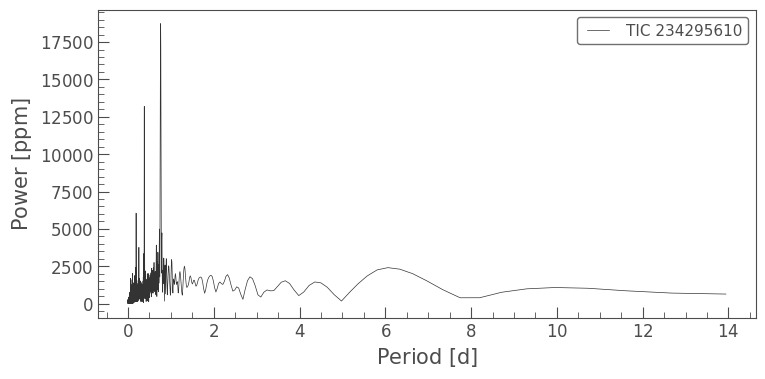

In [24]:
pg.plot();

We see some strong peaks already in just this single light curve. We haven't even performed any processing real processing yet!


 Let's plot this periodogram on a log scale. What do we see? (Describe why there's more noise at the low-frequency end of things. Can we assign "proper" bins?)

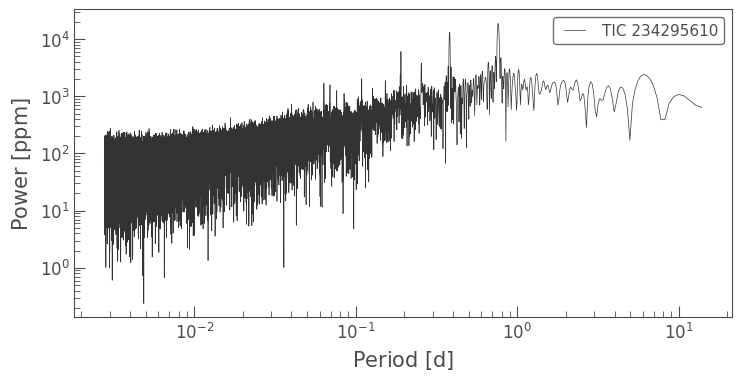

In [26]:
pg.plot(scale='log');

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='Power [$\\mathrm{ppm}$]'>

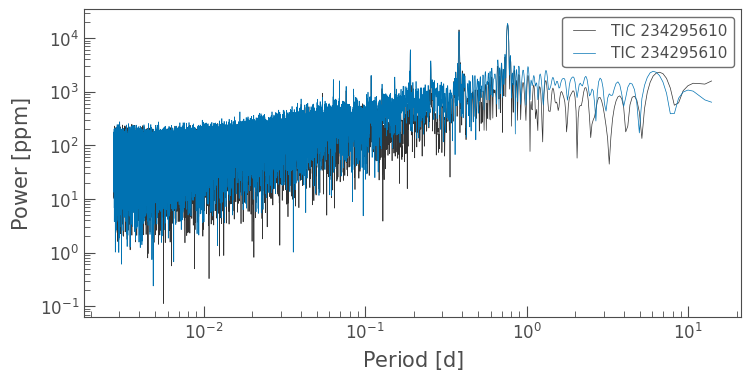

In [29]:
lc_clipped = lc.remove_outliers(sigma=3)

pg_clipped = lc_clipped.normalize(unit='ppm').to_periodogram(maximum_period=max_period)
ax = pg_clipped.plot(scale='log', zorder=1);

pg.plot(ax=ax, scale='log')

If we change this to just the 1-sigma outliers, the periodicity we're looking for is removed entirely.

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='Power [$\\mathrm{ppm}$]'>

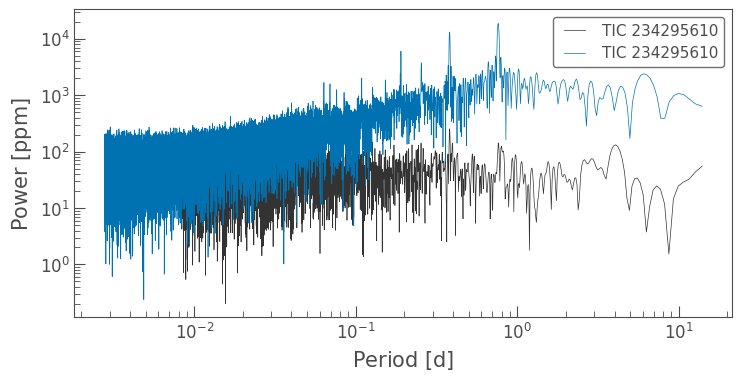

In [30]:
lc_clipped = lc.remove_outliers(sigma=1)

pg_clipped = lc_clipped.normalize(unit='ppm').to_periodogram(maximum_period=max_period)
ax = pg_clipped.plot(scale='log', zorder=1);

pg.plot(ax=ax, scale='log')

This makes sense when we take a look at the lightcurve that's been clipped.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

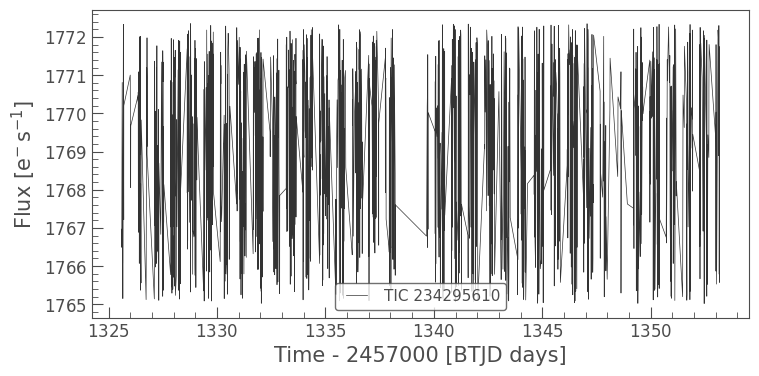

In [31]:
lc_clipped.plot()

In [77]:
# then run it on many light curves at once. Compare to the flare rate derived in the previous notebook
# can we save the previous notebook somewhere else?

# Rotation rates of a larger population
Now let's wrap the above in a function so that we can run it on a number of different objects.

In [107]:
def calc_rotation_rate(name):
    """
    Calculates the roation period of a star, assuming that rotation is the primary driver of the star's periodicity. 
    AS: come back to this?
    
    Inputs
    ------
        :name: name of star (str)
        
    Outputs
    -------
        :period_at_max_power: the dominant period in the light curve. [float]
    """
    
    
    # for all the selected targets, pull the available lightcurves using the lightkurve package
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    lc_interval = (lc.time.max() - lc.time.min()).value

    max_period = lc_interval/2
    
    pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period)

    period_at_max_power = pg.period_at_max_power
    
    return period_at_max_power

We can gather a population of stars using a flare catalog from a previous notebook.

In [97]:
catalog = pd.read_csv('Guenther_2020_flare_catalog.txt')
catalog

,TIC,Outbst,Flare,tpeak,e_tpeak,E_tpeak,Amp,e_Amp,E_Amp,FWHMdt,e_FWHMdt,E_FWHMdt,Ebol,e_Ebol,E_Ebol,MCME,e_MCME,E_MCME
0,2760232,1,1,2.458357e+06,0.000863,0.000854,0.01475,0.00168,0.00170,0.01958,0.00307,0.00375,NaN,NaN,NaN,NaN,NaN,NaN
1,2760232,2,1,2.458358e+06,0.001059,0.001026,0.01389,0.00162,0.00175,0.01612,0.00338,0.00394,NaN,NaN,NaN,NaN,NaN,NaN
2,2760232,3,1,2.458360e+06,0.000026,0.000026,0.28258,0.00817,0.00949,0.00196,0.00017,0.00017,NaN,NaN,NaN,NaN,NaN,NaN
3,2760232,3,2,2.458360e+06,0.000195,0.000195,0.04634,0.00589,0.00598,0.00610,0.00063,0.00062,NaN,NaN,NaN,NaN,NaN,NaN
4,2760232,3,3,2.458360e+06,0.001735,0.001565,0.01665,0.00185,0.00155,0.05816,0.00920,0.00928,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8690,471015484,9,1,2.458371e+06,0.000070,0.000073,0.13585,0.00572,0.00568,0.00254,0.00018,0.00020,NaN,NaN,NaN,NaN,NaN,NaN
8691,471015484,10,1,2.458373e+06,0.000201,0.000249,0.04478,0.00437,0.00442,0.00410,0.00100,0.00100,NaN,NaN,NaN,NaN,NaN,NaN
8692,471015484,10,2,2.458373e+06,0.000323,0.000329,0.02797,0.00334,0.00339,0.00744,0.00207,0.00283,NaN,NaN,NaN,NaN,NaN,NaN
8693,471015484,11,1,2.458379e+06,0.000151,0.000161,0.03871,0.00519,0.00646,0.00266,0.00070,0.00079,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
stars = catalog.TIC.values
stars

array([  2760232,   2760232,   2760232, ..., 471015484, 471015484,
       471015484])

Now, we apply this to the population. The whole population is quite large — if we take every 200th star, then the calculation will only take less than a couple of minutes.

In [111]:
rot_rates = []
for star in tqdm(stars[::200]):
    rot_rate = calc_rotation_rate(str(star))
    
    rot_rates += [rot_rate]

 61%|██████▏   | 27/44 [01:10<00:22,  1.31s/it]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 44/44 [01:32<00:00,  2.10s/it]


We can use a histogram to get a sense of how the periods are distributed.

Text(0, 0.5, 'Count')

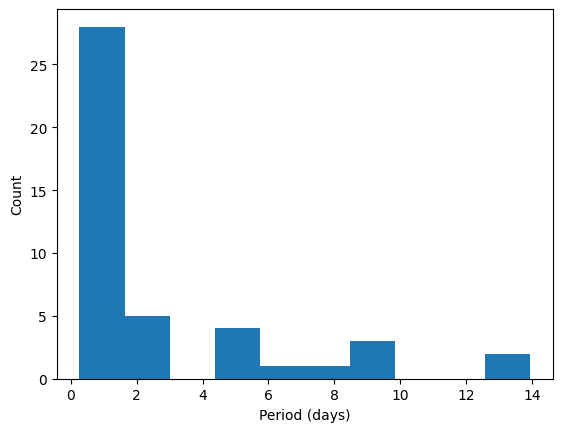

In [114]:
plt.hist(rot_rates)
plt.xlabel('Period (days)')
plt.ylabel('Count')

[Describe this. Broad distribution of days. etc.]

# Assessing flares for this population
In a previous notebook, we trained a convolutional neural network (CNN) to classify stellar flares using the `stella` package (<a href="https://joss.theoj.org/papers/10.21105/joss.02347.pdf">Feinstein et al. 2020</a>). Now, we'll use the code and intuition developed in that notebook to answer the following question: Does a star's rotation rate affect its flaring rate?

In [38]:
# first, we load the mode.
cnn_file = 'initial_flare_model_small_dataset.h5'
model = keras.models.load_model(cnn_file)

In [39]:
# set up the ConvNN object.
cnn_stella = stella.ConvNN(output_dir=data_dir, ds=ds)

Next, let's check that our classifier is working correctly. To do so, we can just apply it to the first light curve we assessed above.

In [64]:
# fig = plt.figure(0, [8, 10])
# cnn_file = 'initial_flare_model_small_dataset.h5'

# for i, lc in enumerate(lcs):
    
#     # pull out on the first light curve in each set, if more than one exist
#     # if len(lc)>0: lc = lc[0]
        
#     # predict the flare probability light cuvey for the input data using `stella` 
#     # (which applies the necessary pre-processing to the data for input to the CNN)
    
#     cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
#     ax = fig.add_subplot(4,2,i+1)
#     im = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
    
#     plt.colorbar(im, ax=ax, label='Probability of Flare')
#     ax.set_xlabel('Time [BJD-2457000]')
#     ax.set_ylabel('Normalized Flux')
#     ax.set_title('TIC {}'.format(lc.targetid));
# plt.tight_layout()
# plt.show()

<Figure size 800x1000 with 0 Axes>

In [65]:
cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


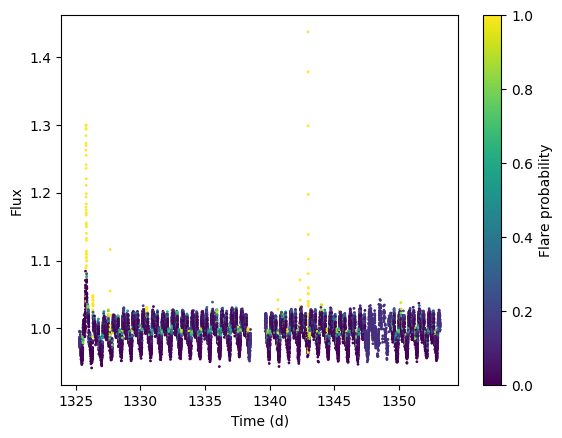

In [72]:
# cnn_stella.predict_flux[0]
fig, ax= plt.subplots()
im  = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
plt.xlabel('Time (d)')
plt.ylabel('Flux') # AS: check units
plt.colorbar(im, label='Flare probability')
plt.show()


This seems to make sense. The "peakiest" parts of the light curves are labeled as flares by our classifier at high probability. To further verify this, we can zoom in and pick out some of the flare morphologgy.

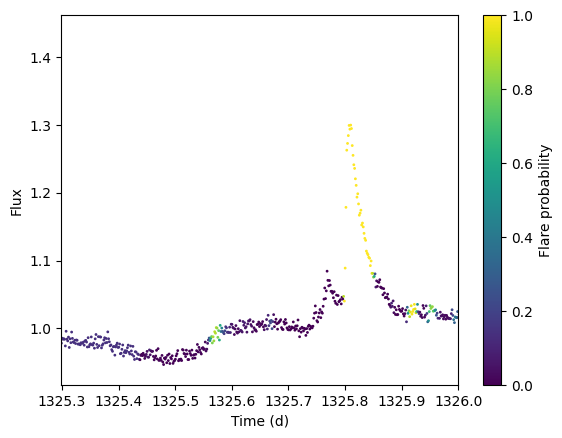

In [76]:
# cnn_stella.predict_flux[0]
fig, ax= plt.subplots()
im  = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
plt.xlabel('Time (d)')
plt.xlim(lc.time.min().value, 1326)
plt.ylabel('Flux') # AS: check units
plt.colorbar(im, label='Flare probability')
plt.show()

In [82]:
import pandas as pd

,TIC,Outbst,Flare,tpeak,e_tpeak,E_tpeak,Amp,e_Amp,E_Amp,FWHMdt,e_FWHMdt,E_FWHMdt,Ebol,e_Ebol,E_Ebol,MCME,e_MCME,E_MCME
0,2760232,1,1,2.458357e+06,0.000863,0.000854,0.01475,0.00168,0.00170,0.01958,0.00307,0.00375,NaN,NaN,NaN,NaN,NaN,NaN
1,2760232,2,1,2.458358e+06,0.001059,0.001026,0.01389,0.00162,0.00175,0.01612,0.00338,0.00394,NaN,NaN,NaN,NaN,NaN,NaN
2,2760232,3,1,2.458360e+06,0.000026,0.000026,0.28258,0.00817,0.00949,0.00196,0.00017,0.00017,NaN,NaN,NaN,NaN,NaN,NaN
3,2760232,3,2,2.458360e+06,0.000195,0.000195,0.04634,0.00589,0.00598,0.00610,0.00063,0.00062,NaN,NaN,NaN,NaN,NaN,NaN
4,2760232,3,3,2.458360e+06,0.001735,0.001565,0.01665,0.00185,0.00155,0.05816,0.00920,0.00928,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8690,471015484,9,1,2.458371e+06,0.000070,0.000073,0.13585,0.00572,0.00568,0.00254,0.00018,0.00020,NaN,NaN,NaN,NaN,NaN,NaN
8691,471015484,10,1,2.458373e+06,0.000201,0.000249,0.04478,0.00437,0.00442,0.00410,0.00100,0.00100,NaN,NaN,NaN,NaN,NaN,NaN
8692,471015484,10,2,2.458373e+06,0.000323,0.000329,0.02797,0.00334,0.00339,0.00744,0.00207,0.00283,NaN,NaN,NaN,NaN,NaN,NaN
8693,471015484,11,1,2.458379e+06,0.000151,0.000161,0.03871,0.00519,0.00646,0.00266,0.00070,0.00079,NaN,NaN,NaN,NaN,NaN,NaN


We see a sharp increase in he flux followed by a slower fall — an example of classic flare morphology (e.g., <a href=https://iopscience.iop.org/article/10.3847/1538-3881/ac6fe6/meta>Mendoza et al. 2022</a>). Looks like the classifier that's working!

In [50]:
# 3 levels. time in flare, count a flare by going to up and then down, or "fit flare", which is harder.

In [51]:
# do this for a bunch of targets, scatter plot, fit a line.

In [52]:
len(cnn_stella.predictions[0][cnn_stella.predictions[0] > 0.5])/len(cnn_stella.predictions[0])

0.061388630519231824

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


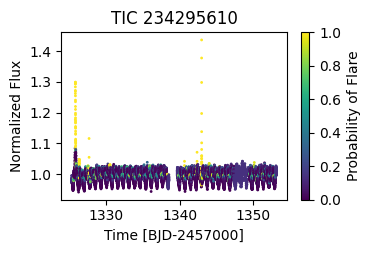

In [57]:
# if len(lc)>0: lc = lc[0]

# predict the flare probability light cuvey for the input data using `stella` 
# (which applies the necessary pre-processing to the data for input to the CNN)
fig = plt.figure(0, [8, 10])

cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)

ax = fig.add_subplot(4,2,i+1)
im = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )

plt.colorbar(im, ax=ax, label='Probability of Flare')
ax.set_xlabel('Time [BJD-2457000]')
ax.set_ylabel('Normalized Flux')
ax.set_title('TIC {}'.format(lc.targetid));

In [60]:
frac_flaring = len(cnn_stella.predictions[0][cnn_stella.predictions[0] > 0.5])/len(cnn_stella.predictions[0])

Text(0, 0.5, 'Period at max power (d)')

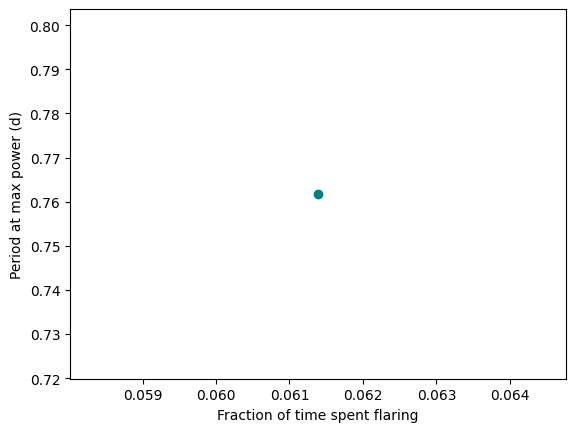

In [62]:
plt.scatter(frac_flaring, pg.period_at_max_power, color='teal')

plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')

That's a single data point! The next step is to do this for the whole  population.

In [127]:
def calc_flare_rate(name):
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    flare_rate = len(cnn_stella.predictions[0][cnn_stella.predictions[0] > 0.5])/len(cnn_stella.predictions[0])
    
    return flare_rate

Running the below for the whole population shouldn't take more than 3-4 minutes.

In [128]:
flare_rates = []
for star in tqdm(stars[::200]):
    flare_rate = calc_flare_rate(str(star))
    
    flare_rates += [flare_rate]

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 1s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

569/569 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

537/537 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

541/541 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step



  0%|          | 0/1 [00:00<?, ?it/s]

554/554 [==============================] - 1s 2ms/step



100%|██████████| 44/44 [02:34<00:00,  3.52s/it]


We first examine our flare rate alone.

Text(0, 0.5, 'Count')

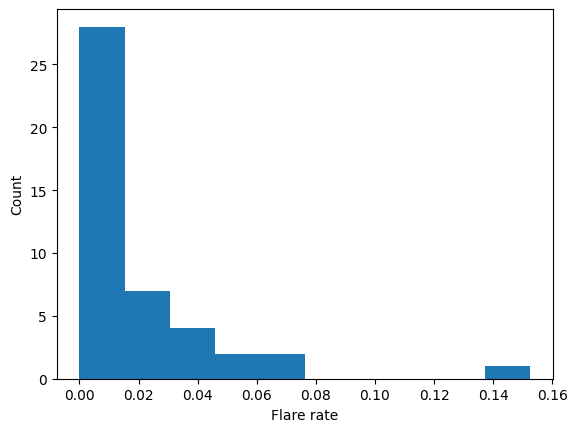

In [129]:
plt.hist(flare_rates)
plt.xlabel('Flare rate')
plt.ylabel('Count')


And now we compare the flare rate to the rotation rate.

In [122]:
rot_rates = [rot_rate.value for rot_rate in rot_rates]

Text(0, 0.5, 'Period at max power (d)')

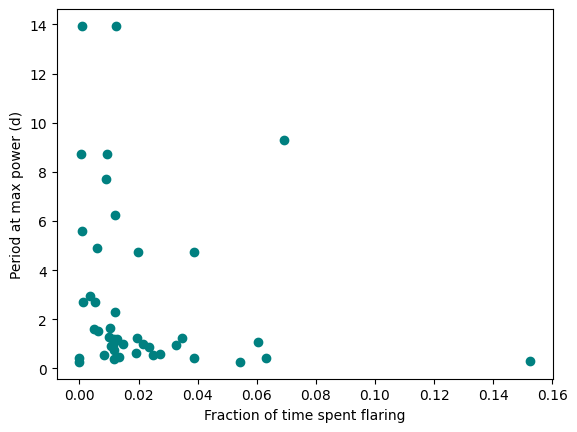

In [130]:
plt.scatter(flare_rates, rot_rates, color='teal')
            
plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')

Now...fit some kind of line? Is there any structure?

In [57]:
# examine sensitivity to detrending

In [ ]:
# why difference between the two methods
# try a different light curve
# compare with flares